# New York CitiBike Data Science Challenge

Der Fahrradverleih CitiBike vermietet in New York über 12.000 Fahrräder an 750 
Verleihstationen. Somit ist CitiBike eine echte Alternative zu den herkömmlichen 
Transportmitteln, wie z.B. U-bahn oder Taxi. 

Nehme an, es wäre das Jahr 2018. Mit einem gültigen 24 Stunden (3 Tage) Pass bzw. einer 
jährlichen Mitgliedschaft können Kunden ein Fahrrad an einer Verleihstation abholen und an 
einer beliebigen Station wieder abgeben. CitiBike stellt die durch den Verleih gesammelten 
Daten der Öffentlichkeit zur Verfügung. Deine Aufgabe als Data Scientist ist es, CitiBike dabei zu
helfen diese Daten wertstiftend zu nutzen. 

In einem ersten Pilotprojekt sollst du hierfür die Daten analysieren und ein Modell bauen, mit 
welchem zwei Klassen von Nutzern identifiziert werden können; dies sind (i) customers (24 
Stunden/ 3 Tage Pass) und (ii) subscribers (jährliche Mitgliedschaft).

Eine Orientierungshilfe bei 
dieser Aufgabenstellung bieten dir die folgenen Arbeitsschritte:
 
1. Lade diese Daten von Citibike für das Jahr 2018 herunter. Mach dich mit dem Inhalt des 
Datensatzes vertraut und bereite ihn für weitere Analysen auf. 
2. Visualisiere die Daten; sei kreativ und überlege dir geeignete Darstellungsformen für 
deine Entdeckungen. Nutze die Visualisierungen auch in deiner Ergebnispräsentation um 
deine Argumente zu unterstützen.
3. Überlege dir geeignete Features (Merkmale) als Input für dein customer-subscriber-
Modell. Konstruiere gegebenenfalls neue Features um dein Modell zu verbessern. 
4. Verteste verschiedene Modelle bzw. Methoden zur Klassifikation der Kundentypen 
subscribers und customers. Evaluiere die Performance der unterschiedlichen Modelle 
und begründe eine Modellauswahl.
5. Skizziere mögliche Einsatzgebiete oder UseCases deiner Modelle
6. Skizziere für CitiBike Kooperationsmöglichkeiten mit einer Versicherung (und/oder 
umgekehrt). 
 


## Imports und Co

In [2]:
# Generelles
import os
import tqdm.auto

# Data science
import numpy as np
import pandas as pd

# Machine learning
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

# Plotting
import matplotlib.pyplot as plt

# Hilfen
from utils import crow_distance
from utils import forward_feature_selection

# Display
pd.set_option('display.max_columns', 500)
%matplotlib inline 

# Random seed
random_seed = 1
np.random.seed(random_seed)

# Konstanten
data_drop = 0.99
max_trip_duration = 12 * 3600

## Datenvorbereitung

In [4]:
# Rohdaten einlesen
data_directory = 'data/'
files = sorted(os.listdir(data_directory))
for index, file in enumerate(files):
    if index == 0:
        data = pd.read_csv(data_directory+file)
        data.drop(np.random.choice(data.index, int(len(data)*data_drop), replace=False), inplace=True)
    else:
        data_tmp = pd.read_csv(data_directory+file)
        data_tmp.drop(np.random.choice(data_tmp.index, int(len(data_tmp)*data_drop), replace=False), inplace=True)
        data = pd.concat([data, data_tmp], ignore_index=True)

# Datentypen verbessern
for column in data.columns:
    data.rename(columns={column: column.replace(' ', '_')}, inplace=True)
data.starttime = pd.to_datetime(data.starttime)
data.stoptime = pd.to_datetime(data.stoptime)

# Rohdaten sichten
data

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,694,2018-01-02 14:27:49.623,2018-01-02 14:39:24.127,72.0,W 52 St & 11 Ave,40.767272,-73.993929,484.0,W 44 St & 5 Ave,40.755003,-73.980144,32375,Subscriber,1967,1
1,904,2018-01-10 23:12:18.100,2018-01-10 23:27:23.062,72.0,W 52 St & 11 Ave,40.767272,-73.993929,284.0,Greenwich Ave & 8 Ave,40.739017,-74.002638,21175,Subscriber,1992,1
2,822,2018-01-13 10:50:01.962,2018-01-13 11:03:44.365,72.0,W 52 St & 11 Ave,40.767272,-73.993929,484.0,W 44 St & 5 Ave,40.755003,-73.980144,30984,Subscriber,1970,1
3,1817,2018-01-15 12:02:01.845,2018-01-15 12:32:19.318,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3372.0,E 74 St & 1 Ave,40.768974,-73.954823,29381,Subscriber,1991,1
4,669,2018-01-16 15:22:32.431,2018-01-16 15:33:41.570,72.0,W 52 St & 11 Ave,40.767272,-73.993929,525.0,W 34 St & 11 Ave,40.755942,-74.002116,30054,Subscriber,1956,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175485,1379,2018-12-31 19:16:08.971,2018-12-31 19:39:08.741,440.0,E 45 St & 3 Ave,40.752554,-73.972826,362.0,Broadway & W 37 St,40.751726,-73.987535,20652,Customer,1969,0
175486,403,2018-12-31 20:13:49.017,2018-12-31 20:20:32.064,340.0,Madison St & Clinton St,40.712690,-73.987763,332.0,Cherry St,40.712199,-73.979481,15008,Subscriber,1992,1
175487,241,2018-12-31 20:28:38.775,2018-12-31 20:32:39.789,3318.0,2 Ave & E 96 St,40.783964,-73.947167,3379.0,E 103 St & Lexington Ave,40.790305,-73.947558,16254,Subscriber,1988,1
175488,103,2018-12-31 21:20:31.023,2018-12-31 21:22:14.777,3619.0,Newtown Ave & 23 St,40.771361,-73.924615,3614.0,Crescent St & 30 Ave,40.768692,-73.924957,20328,Subscriber,1967,1


In [3]:
# Sanity checks der Rohdaten

print('Tripduration')
print(f'Min: {np.min(data.tripduration)} s, Max: {np.max(data.tripduration)/3600:.0f} h\n')

print('Starttime')
print(f'Min: {np.min(data.starttime)}, Max: {np.max(data.starttime)}\n')

print('Stoptime')
print(f'Min: {np.min(data.stoptime)}, Max: {np.max(data.stoptime)}\n')

print('Start station id')
print(f'Min: {np.min(data.start_station_id)}, Max: {np.max(data.start_station_id)}, #: {len(np.unique(data.start_station_id))}\n')

# print('Start station name')
# print(f'#: {len(np.unique(data.start_station_name))}\n')
      
print('Start station latitude')
print(f'Min: {np.min(data.start_station_latitude)}, Max: {np.max(data.start_station_latitude)}, #: {len(np.unique(data.start_station_latitude))}\n')

print('Start station longtude')
print(f'Min: {np.min(data.start_station_longitude)}, Max: {np.max(data.start_station_longitude)}, #: {len(np.unique(data.start_station_longitude))}\n')

print('End station id')
print(f'Min: {np.min(data.end_station_id)}, Max: {np.max(data.end_station_id)}, #: {len(np.unique(data.end_station_id))}\n')

# print('End station name')
# print(f'#: {len(np.unique(data.end_station_name))}\n')

print('End station latitude')
print(f'Min: {np.min(data.end_station_latitude)}, Max: {np.max(data.end_station_latitude)}, #: {len(np.unique(data.end_station_latitude))}\n')

print('End station longitude')
print(f'Min: {np.min(data.end_station_longitude)}, Max: {np.max(data.end_station_longitude)}, #: {len(np.unique(data.end_station_longitude))}\n')

print('Bikeid')
print(f'Min: {np.min(data.bikeid)}, Max: {np.max(data.bikeid)}, #: {len(np.unique(data.bikeid))}\n')

print('Usertype')
print(f'Types: {np.unique(data.usertype)}, #: {np.unique(data.usertype, return_counts=True)[1]}\n')

print('Birth year')
print(f'Min: {np.min(data.birth_year)}, Max: {np.max(data.birth_year)}\n')

print('Gender')
print(f'Types: {np.unique(data.gender)}, #: {np.unique(data.gender, return_counts=True)[1]}\n')

Tripduration
Min: 61 s, Max: 1342 h

Starttime
Min: 2018-01-01 00:56:02.704000, Max: 2018-12-31 22:49:13.365000

Stoptime
Min: 2018-01-01 01:04:32.800000, Max: 2018-12-31 22:58:57.147000

Start station id
Min: 72.0, Max: 3721.0, #: 805

Start station latitude
Min: 40.64653836709648, Max: 40.866, #: 814

Start station longtude
Min: -74.02535319328308, Max: -73.887, #: 814

End station id
Min: 72.0, Max: 3721.0, #: 809

End station latitude
Min: 40.64653836709648, Max: 40.863, #: 817

End station longitude
Min: -74.02535319328308, Max: -73.878, #: 819

Bikeid
Min: 14529, Max: 35806, #: 14664

Usertype
Types: ['Customer' 'Subscriber'], #: [ 19420 156070]

Birth year
Min: 1885, Max: 2002

Gender
Types: [0 1 2], #: [ 14988 119913  40589]



In [4]:
# Daten säubern

# Sortiere Fahrten aus, die länger als 12 Stunden dauerten. Hier lag anscheinend ein Fehler vor.
len_before = len(data)
data.drop(data[data.tripduration >= max_trip_duration].index, inplace=True)
len_after = len(data)
print(f'Dropped {len_before-len_after} lines due to excessive tripduration')

Dropped 72 lines due to excessive tripduration


### Erstes Fazit zu den Daten

- Der Datensatz ist sehr groß, wir beschränken uns deswegen auf 1% der Daten, um meine virtuelle Maschine zu schonen. Durch random sampling werden Charakteristika des Datensatzes erhalten
- Datensatz ist 'imbalanced', ~19 000 customer gegen ~156 000 subscriber
- Datenqualität ist okay, aber es gibt ein paar sehr alte Kunden, lange Fahrten und unhomogene Koordinatenangaben
- Wir sollten schon vor der weiteren Analyse einen Teil der Daten beiseitelegen, um eine wirklich unabhängige Evaluation unserer Modelle zu erreichen
- Wir sollten schon bei der visuellen Analyse des Datensatzes die Aufgabenstellung im Auge behalten

### Weiterführende Überlegungen

- Man könnte den Datensatz anders samplen. Wir haben genug Daten um einen Datensatz zu erstellen der 50% Customer und 50% Subscriber hat, und so das imbalanced data Problem umgehen
- Man könnte auch kompletten Datensatz zum Training verwenden, ich bin nur nicht sicher ob das die Performance des Modells erhöht (man könnte um das herauszufinden die Datenmenge sukzessive erhöhen bis zur Konvergenz), und wie man das technisch realisieren könnte (hängt von der verfügbaren Hardware ab)

## Features für Customer-Subscriber-Modell

In [7]:
data['start_hour_of_day']= [t.hour for t in data.starttime]

data['start_day_of_week'] = [t.dayofweek for t in data.starttime]

data['start_day_of_year'] = [t.dayofyear for t in data.starttime]

data['duration_seconds'] = data.tripduration

data['crow_distance_meters'] = crow_distance(data.start_station_latitude, data.start_station_longitude, data.end_station_latitude, data.end_station_longitude)

data['crow_velocity_meters_per_second'] = data.crow_distance_meters / data.duration_seconds

data['age_years'] = 2018 - data.birth_year

data['gender_male'] = [1 if g==1 else 0 for g in data.gender]

data['gender_female'] = [1 if g==2 else 0 for g in data.gender]

data['gender_unknown'] = [1 if g==0 else 0 for g in data.gender]

data['customer'] = [1 if u=='Customer' else 0 for u in data.usertype]

data['subscriber'] = [1 if u=='Subscriber' else 0 for u in data.usertype]

data['set'] = [np.random.choice(['train', 'dev', 'test'], p=[0.8, 0.1, 0.1]) for r in range(len(data))]

data['train_set'] = [True if s=='train' else False for s in data.set]

data['dev_set'] = [True if s=='dev' else False for s in data.set]

data['test_set'] = [True if s=='test' else False for s in data.set]

data

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour_of_day,start_day_of_week,start_day_of_year,duration_seconds,crow_distance_meters,crow_velocity_meters_per_second,age_years,gender_male,gender_female,gender_unknown,customer,subscriber,set,train_set,dev_set,test_set
0,694,2018-01-02 14:27:49.623,2018-01-02 14:39:24.127,72.0,W 52 St & 11 Ave,40.767272,-73.993929,484.0,W 44 St & 5 Ave,40.755003,-73.980144,32375,Subscriber,1967,1,14,1,2,694,1997.468764,2.878197,51,1,0,0,0,1,train,True,False,False
1,904,2018-01-10 23:12:18.100,2018-01-10 23:27:23.062,72.0,W 52 St & 11 Ave,40.767272,-73.993929,284.0,Greenwich Ave & 8 Ave,40.739017,-74.002638,21175,Subscriber,1992,1,23,2,10,904,3368.778580,3.726525,26,1,0,0,0,1,train,True,False,False
2,822,2018-01-13 10:50:01.962,2018-01-13 11:03:44.365,72.0,W 52 St & 11 Ave,40.767272,-73.993929,484.0,W 44 St & 5 Ave,40.755003,-73.980144,30984,Subscriber,1970,1,10,5,13,822,1997.468764,2.430011,48,1,0,0,0,1,train,True,False,False
3,1817,2018-01-15 12:02:01.845,2018-01-15 12:32:19.318,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3372.0,E 74 St & 1 Ave,40.768974,-73.954823,29381,Subscriber,1991,1,12,0,15,1817,3137.760106,1.726891,27,1,0,0,0,1,train,True,False,False
4,669,2018-01-16 15:22:32.431,2018-01-16 15:33:41.570,72.0,W 52 St & 11 Ave,40.767272,-73.993929,525.0,W 34 St & 11 Ave,40.755942,-74.002116,30054,Subscriber,1956,1,15,1,16,669,1418.276118,2.119994,62,1,0,0,0,1,train,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175485,1379,2018-12-31 19:16:08.971,2018-12-31 19:39:08.741,440.0,E 45 St & 3 Ave,40.752554,-73.972826,362.0,Broadway & W 37 St,40.751726,-73.987535,20652,Customer,1969,0,19,0,365,1379,1178.439619,0.854561,49,0,0,1,1,0,train,True,False,False
175486,403,2018-12-31 20:13:49.017,2018-12-31 20:20:32.064,340.0,Madison St & Clinton St,40.712690,-73.987763,332.0,Cherry St,40.712199,-73.979481,15008,Subscriber,1992,1,20,0,365,403,683.279021,1.695481,26,1,0,0,0,1,train,True,False,False
175487,241,2018-12-31 20:28:38.775,2018-12-31 20:32:39.789,3318.0,2 Ave & E 96 St,40.783964,-73.947167,3379.0,E 103 St & Lexington Ave,40.790305,-73.947558,16254,Subscriber,1988,1,20,0,365,241,771.588394,3.201612,30,1,0,0,0,1,test,False,False,True
175488,103,2018-12-31 21:20:31.023,2018-12-31 21:22:14.777,3619.0,Newtown Ave & 23 St,40.771361,-73.924615,3614.0,Crescent St & 30 Ave,40.768692,-73.924957,20328,Subscriber,1967,1,21,0,365,103,318.976246,3.096857,51,1,0,0,0,1,train,True,False,False


## Visualisierungen

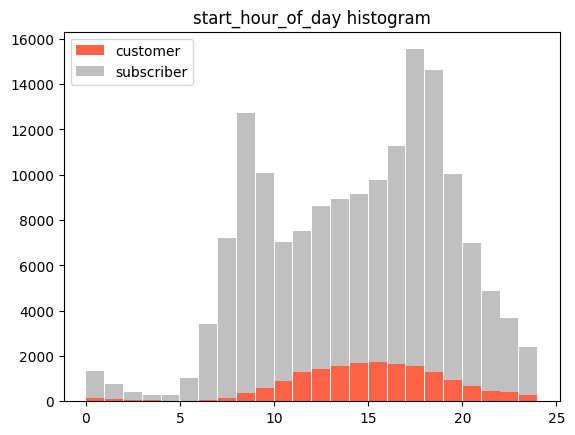

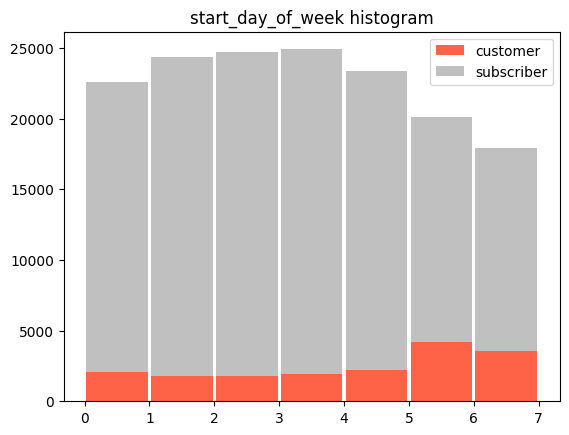

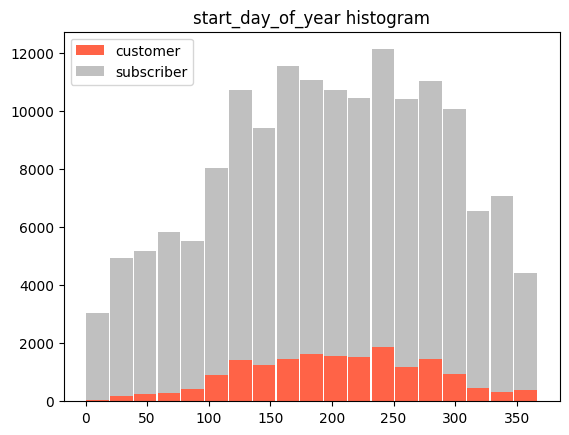

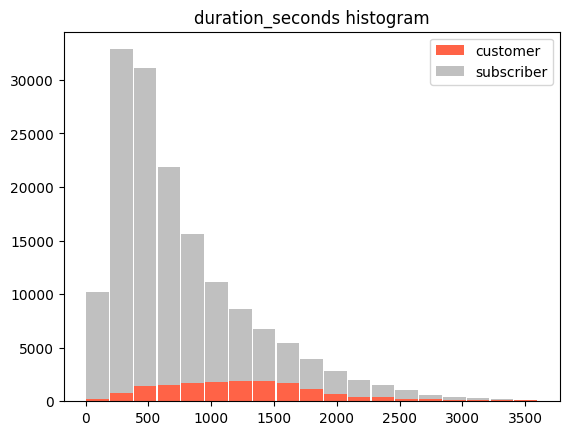

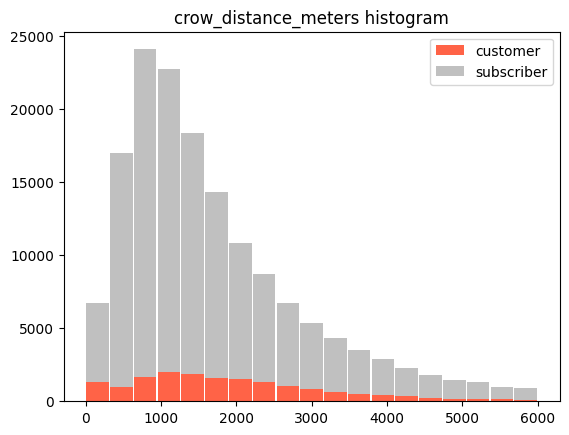

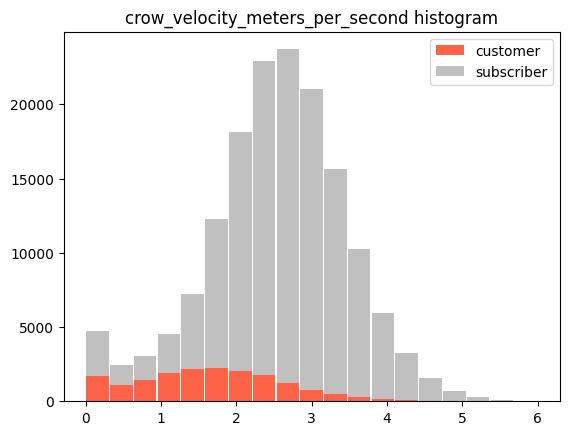

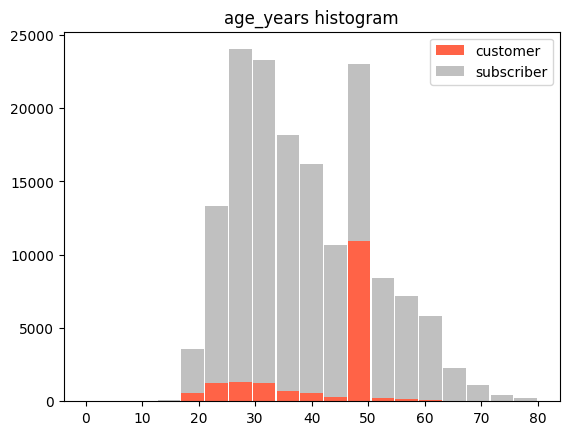

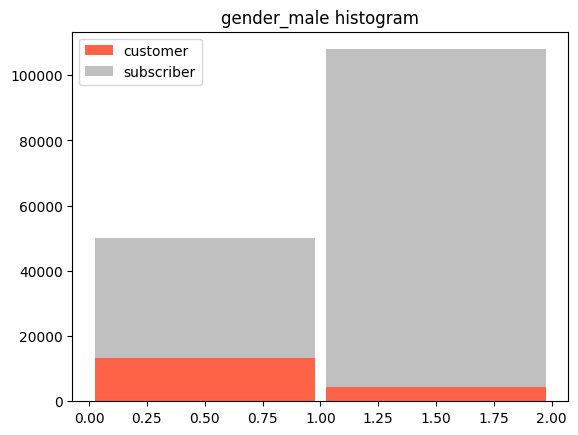

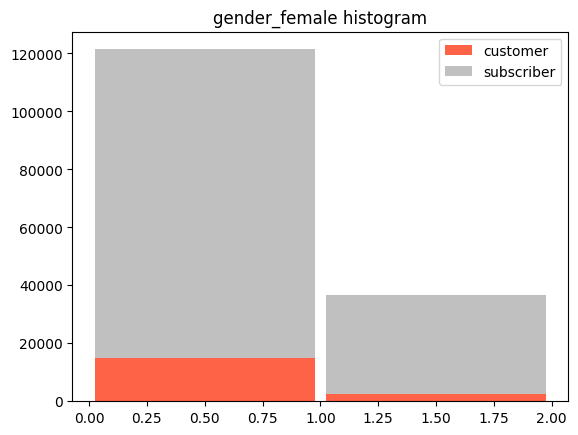

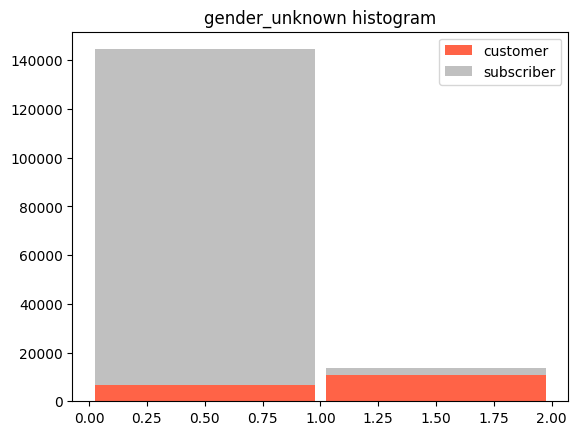

In [6]:
# histogramme, sortiert nach customer und Subscriber
plot_specs = [('start_hour_of_day', range(25)),
              ('start_day_of_week', range(8)),
              ('start_day_of_year', np.linspace(0, 367, num=20)),
              ('duration_seconds', np.linspace(0, 3600, num=20)),
              ('crow_distance_meters', np.linspace(0, 6000, num=20)),
              ('crow_velocity_meters_per_second', np.linspace(0, 6, num=20)),
              ('age_years', np.linspace(0, 80, num=20)),
              ('gender_male', range(3)),
              ('gender_female', range(3)),
              ('gender_unknown', range(3))]

data_customer = data[~data.test_set & data.customer==1]
data_subscriber = data[~data.test_set & data.subscriber==1]

for column, bins in plot_specs:
    plt.hist([data_customer[column], data_subscriber[column]], bins, stacked=True, rwidth=.95, color=['tomato', 'silver'])
    plt.title(f'{column} histogram')
    plt.legend(['customer', 'subscriber'])
    plt.show()
    plt.close()

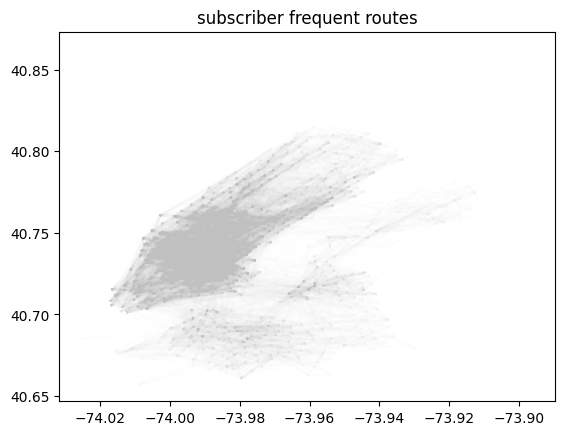

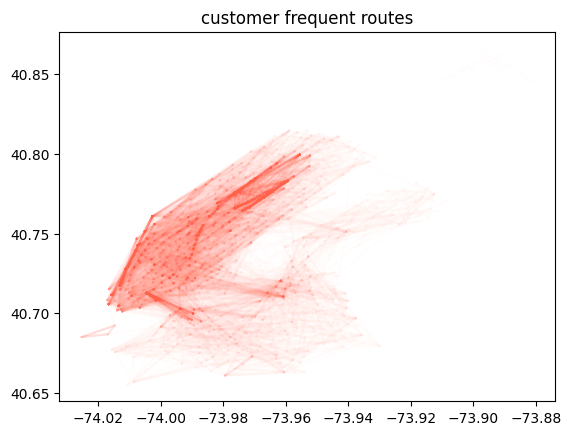

In [7]:
# Wegstrecken, ebenfalls nach customer und subscriber 
N = 10000

data_subscriber_for_plot = data_subscriber.sample(n=N)
for idx, row in data_subscriber_for_plot.iterrows():
    plt.plot([row.start_station_longitude, row.end_station_longitude], [row.start_station_latitude, row.end_station_latitude], alpha=0.01, color='silver')
plt.title('subscriber frequent routes')
plt.show()
plt.close()

data_customer_for_plot = data_customer.sample(n=N)
for idx, row in data_customer_for_plot.iterrows():
    plt.plot([row.start_station_longitude, row.end_station_longitude], [row.start_station_latitude, row.end_station_latitude], alpha=0.01, color='tomato')
plt.title('customer frequent routes')
plt.show()
plt.close()

### Fazit zur Datenanalyse

- Subscriber fahren häufig zur Rush Hour
- Customer fahren langsamer und kürzere Strecken (Rundwege) und am Wochenende
- Customer geben oft kein Geschlecht und ein standard-Alter an
- Strukturierter Datensatz ideal für entscheidungsbsaumbasiertes Modell

### Weiterführende Überlegungen zu den Daten

- Indem wir diese Features nutzen, nutzen wir die raumzeitliche Struktur der Daten kaum 
- Man könnte andere Daten hinzunehmen, z.B. meteorologische Daten oder Stadtviertel

## Modelle zur Customer/Subscriber Klassifikation

In [8]:
# Inputs definieren
feature_columns = ['start_hour_of_day',
                   'start_day_of_week',
                   'start_day_of_year',
                   'duration_seconds',
                   'crow_distance_meters',
                   'crow_velocity_meters_per_second',
                   'age_years',
                   'gender_male',
                   'gender_female',
                   'gender_unknown']

target_column = ['customer']

# Training und validation Daten
x_train = data.loc[data.train_set, feature_columns]
x_dev = data.loc[data.dev_set, feature_columns]
y_train = data.loc[data.train_set, target_column]
y_dev = data.loc[data.dev_set, target_column]

In [13]:
# Simples Modell: immer als Subscriber klassifizieren
simple_model = lambda x: np.array([0]*len(x)) 
y_dev_hat_simple = simple_model(x_dev)

# Lineare Klassifikation fitten
linear_model = SGDClassifier(max_iter=1000, tol=1e-13)
linear_model.fit(x_train, y_train.to_numpy().reshape(-1))
y_dev_hat_linear = linear_model.predict(x_dev)

# Random forest für Klassifikation fitten
random_forest_model = RandomForestClassifier(n_estimators=500)
random_forest_model.fit(x_train, y_train.to_numpy().reshape(-1))
y_dev_hat_random_forest = random_forest_model.predict(x_dev)

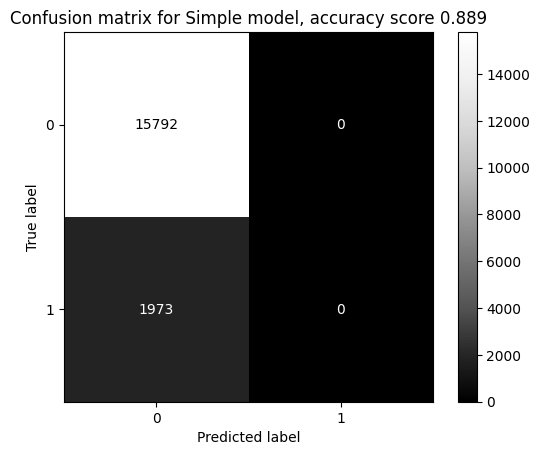

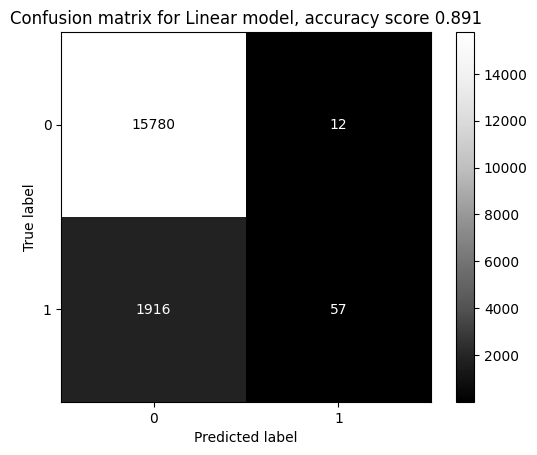

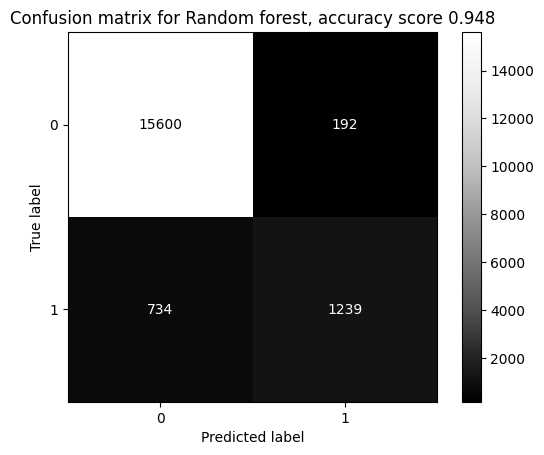

In [19]:
# Konfusionsmatrizen und accuracy score
plot_specs = [(y_dev_hat_simple, 'simple model'),
              (y_dev_hat_linear, 'linear model'),
              (y_dev_hat_random_forest, 'random forest')]
for y_dev_hat, model_name in plot_specs:
    acc = accuracy_score(y_dev, y_dev_hat)
    disp = ConfusionMatrixDisplay.from_predictions(y_dev, y_dev_hat, cmap='Greys_r')
    plt.title(f'confusion matrix for {model_name}, accuracy score {acc:.3f}')
    plt.show()
    plt.close()

100%|===================| 999/1000 [06:30<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


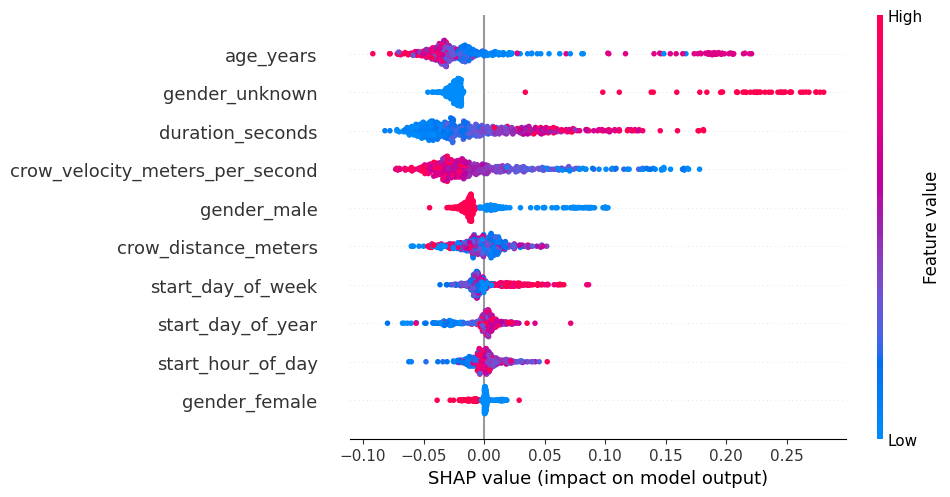

In [20]:
# Wie trifft der random forest Entscheidungen?
N = 500
x_dev_for_shap = x_dev.sample(n=N)

explainer = shap.TreeExplainer(random_forest_model, x_dev_for_shap)
shap_values = explainer(x_dev_for_shap)
shap.plots.beeswarm(shap_values[:, :, 1])

In [24]:
# Welche features sind am nützlichsten für die Klassifikation?
forward_feature_selection(data, feature_columns, target_column)


testing 2 features:
start_hour_of_day, start_day_of_week: acc = 0.8889
start_hour_of_day, start_day_of_year: acc = 0.8864
start_hour_of_day, duration_seconds: acc = 0.8709
start_hour_of_day, crow_distance_meters: acc = 0.8375
start_hour_of_day, crow_velocity_meters_per_second: acc = 0.8381
start_hour_of_day, age_years: acc = 0.9341
start_hour_of_day, gender_male: acc = 0.8887
start_hour_of_day, gender_female: acc = 0.8889
start_hour_of_day, gender_unknown: acc = 0.9408
start_day_of_week, start_day_of_year: acc = 0.8889
start_day_of_week, duration_seconds: acc = 0.8820
start_day_of_week, crow_distance_meters: acc = 0.8463
start_day_of_week, crow_velocity_meters_per_second: acc = 0.8397
start_day_of_week, age_years: acc = 0.9316
start_day_of_week, gender_male: acc = 0.8889
start_day_of_week, gender_female: acc = 0.8889
start_day_of_week, gender_unknown: acc = 0.9395
start_day_of_year, duration_seconds: acc = 0.8700
start_day_of_year, crow_distance_meters: acc = 0.8550
start_day_of_year,

### Zwischenfazit zu Modellen

- Wegen des 'imbalanced' Datasets bekommen wir bereits mit dem simplen Modell gute Vorhersagen
- Random forest ist deutlich besser, Explainable Machine Learning Methoden liefern plausible Ergebnisse
- Random forest verlässt sich zu einem Großteil auf die fehlenden/unzuverlässigen Angaben der Customer. Daraus lassen sich schlecht weitere Verhaltensmuster ableiten

### Und nun?
- Wir versuchen zu trennen: wie viel Information steckt in fehlenden Angaben, wie viel im Fahrverhalten?

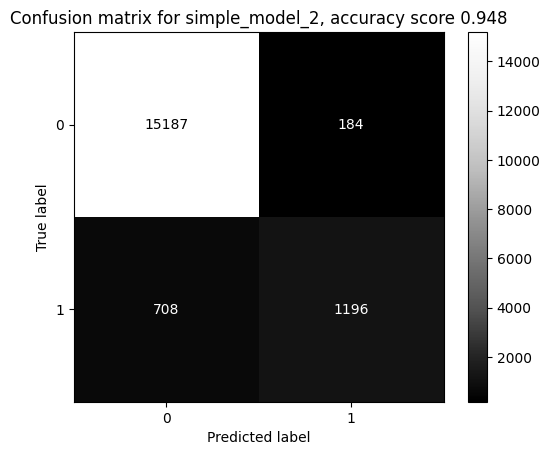

In [12]:
# Zweites Simples Modell: Klassifiziere als Customer, wenn das Geschlecht unbekannt ist und Alter=Standardalter 49 oder sehr alt
def simple_model_2(x):
    y = np.array([0] * len(x))
    customer_indices = [((x.age_years==49)|(x.age_years>80))&(x.gender_unknown==1)][0]
    y[customer_indices] = 1
    return y
    
# Testen und visualisieren
y_dev_hat_simple_2 = simple_model_2(x_dev)
acc = accuracy_score(y_dev, y_dev_hat_simple_2)
disp = ConfusionMatrixDisplay.from_predictions(y_dev, y_dev_hat_simple_2, cmap='Greys_r')
plt.title(f'Confusion matrix for simple_model_2, accuracy score {acc:.3f}')
plt.show()
plt.close()


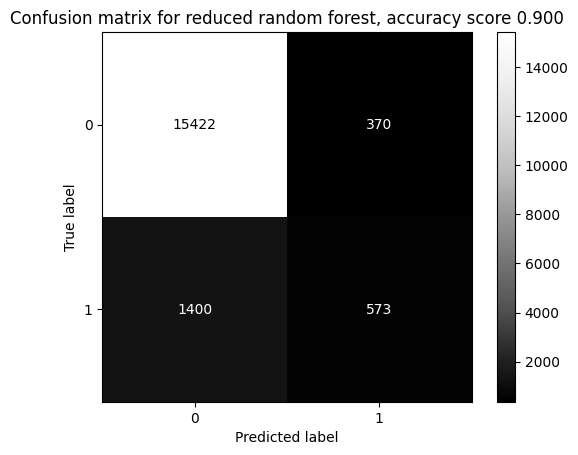

In [21]:
# Random forest nur mit Fahrverhalten
# Inputs definieren
feature_columns_r = ['start_hour_of_day',
                   'start_day_of_week',
                   'start_day_of_year',
                   'duration_seconds',
                   'crow_distance_meters',
                   'crow_velocity_meters_per_second',
                   # 'age',
                   # 'gender_male',
                   # 'gender_female',
                   # 'gender_unknown'
                  ]

target_column = ['customer']

# Training und validation Daten
x_train_r = data.loc[data.train_set, feature_columns_r]
x_dev_r = data.loc[data.dev_set, feature_columns_r]
y_train = data.loc[data.train_set, target_column]
y_dev = data.loc[data.dev_set, target_column]

# Random forest auf reduzierten Daten fitten
random_forest_model_r = RandomForestClassifier(n_estimators=500)
random_forest_model_r.fit(x_train_r, y_train.to_numpy().reshape(-1))
y_dev_hat_random_forest_r = random_forest_model_r.predict(x_dev_r)

# Testen und visualisieren
acc = accuracy_score(y_dev, y_dev_hat_random_forest_r)
disp = ConfusionMatrixDisplay.from_predictions(y_dev, y_dev_hat_random_forest_r, cmap='Greys_r')
plt.title(f'Confusion matrix for reduced random forest, accuracy score {acc:.3f}')
plt.show()
plt.close()

### Fazit

- Wir haben ein simples, 100% transparentes und erklärbares Modell mit guter Performance, welches leider nicht auf dem Fahrverhalten basiert
- Der random forest, der nur auf Features zum Fahrverhalten basiert liefert leider nicht so gute Ergebnisse wie der random forest der auf allen Features trainiert wurde
 - Vorerst wählen wir das simple Modell und den random forest mit allen Features als finale Modelle aus und testen sie mit dem unabhängigen Test Set

 ### Weiterführende Überlegungen
 
 - Eine Graph Machine Learning Methode könnte das Fahrverhalten effektiver analysieren
 - Wie akkurat kann das Modell werden? Dazu können wir schauen, wie viele Fahrten gleiche Features haben, obwohl sie unterschiedlichen Klassen angehören

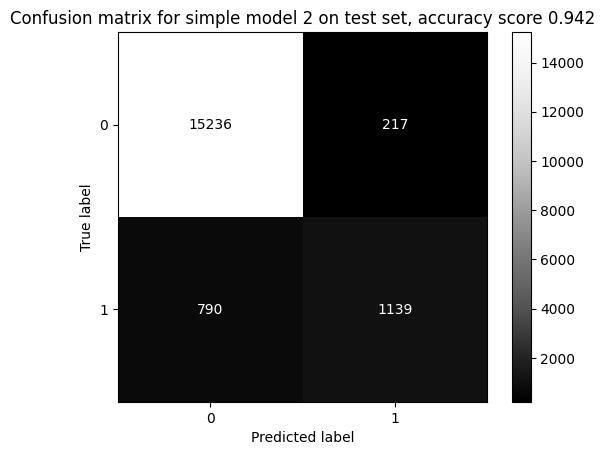

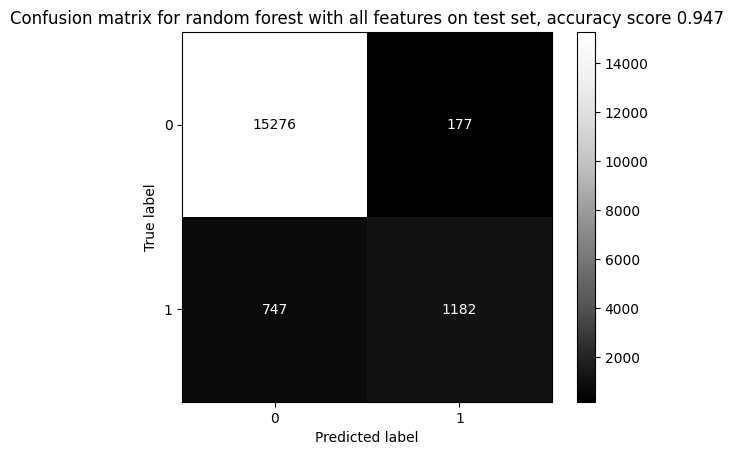

In [19]:
# Zwei Finale Modelle
x_test = data.loc[data.test_set, feature_columns]
y_test = data.loc[data.test_set, target_column]
y_test_hat_simple_model_2 = simple_model_2(x_test)
y_test_hat_random_forest_model = random_forest_model.predict(x_test)

acc = accuracy_score(y_test, y_test_hat_simple_model_2)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat_simple_model_2, cmap='Greys_r')
plt.title(f'Confusion matrix for simple model 2 on test set, accuracy score {acc:.3f}')
plt.show()
plt.close()

acc = accuracy_score(y_test, y_test_hat_random_forest_model)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat_random_forest_model, cmap='Greys_r')
plt.title(f'Confusion matrix for random forest with all features on test set, accuracy score {acc:.3f}')
plt.show()
plt.close()


## Use cases für Modelle

- Wir wissen weniger über Customer als über Subscriber, deshalb können wir schlechter auf diese Zielgruppe eingehen
- Fahrräder bereitstellen (https://www.fox5ny.com/news/citi-bike-empty-docks)
- Kundenelastizität, vielleicht Pauschale erhöhen?
- Städteplanung, neue Fahrradwege

##  Kooperation mit Versicherung

- Gratulation zur subsciber base!
- Über subscriber wissen wir weniger, deshalb schwieriger zu versichern
- Unfallversicherung möglich, ähnlich wie bei Autos haben wir viele Daten um den Versicherten Gegenstand statistisch zu betrachten